In [1]:
import torch
from eval import auc, precision_at_k
import matplotlib.pyplot as plt
import scienceplots


In [2]:
preds = torch.load('/home/jrm28/fairness/subgraph_sketching-original/src/results/facebook_20231117-103057/facebook_0_149.pth', map_location=torch.device('cpu'))
adv_preds = torch.load('/home/jrm28/fairness/subgraph_sketching-original/src/results/facebook_20231117-103057/facebook_0_149_adv.pth', map_location=torch.device('cpu'))

## Prec@K **with** intervention

In [3]:
## Error within the same groups
## i.e. when both are protected or both are not protected
same_group_mask = (adv_preds['test_true_adv'].argmax(1) == 0) | (adv_preds['test_true_adv'].argmax(1) == 2)
inter_group_mask = (adv_preds['test_true_adv'].argmax(1) == 1)
protected_group_mask = (adv_preds['test_true_adv'].argmax(1) == 2)
unprotected_group_mask = (adv_preds['test_true_adv'].argmax(1) == 0)

auc(preds['test_true'][same_group_mask], preds['test_pred'][same_group_mask]), auc(preds['test_true'][inter_group_mask], preds['test_pred'][inter_group_mask])

(0.9571127891540527, 0.9655648469924927)

### Same group vs Inter group

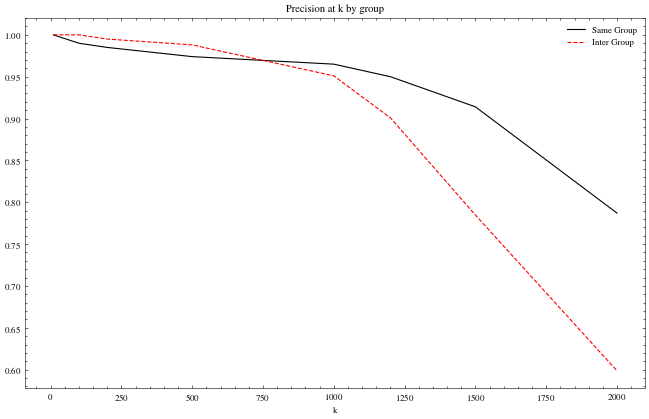

In [4]:
same_group_results, inter_group_results, protected_group_results, unprotected_group_results = [], [], [], []
ks = [10, 100, 200, 500, 1000, 1200, 1500, 2000]
for k in ks:
    same_group_results.append(precision_at_k(preds['test_true'][same_group_mask], preds['test_pred'][same_group_mask], k))
    inter_group_results.append(precision_at_k(preds['test_true'][inter_group_mask], preds['test_pred'][inter_group_mask], k))
    # protected_group_results.append(precision_at_k(preds['test_true'][protected_group_mask], preds['test_pred'][protected_group_mask], k))
    # unprotected_group_results.append(precision_at_k(preds['test_true'][unprotected_group_mask], preds['test_pred'][unprotected_group_mask], k))

plt.figure(figsize=(10, 6), dpi=80)

plt.rcdefaults()
plt.style.use(['science','ieee', 'no-latex'])
plt.plot(ks, same_group_results, label='Same Group')
plt.plot(ks, inter_group_results, label='Inter Group')

plt.title("Precision at k by group")
plt.legend()
plt.xlabel('k')
plt.show();

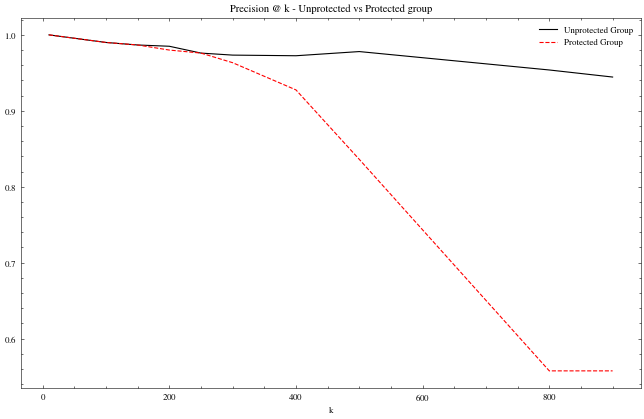

In [5]:
protected_group_results, unprotected_group_results = [], []
# ks = [10, 100, 200, 500, 1000, 1200, 1500, 2000]
ks = [10, 100, 150, 200, 250, 300, 400, 500, 800, 900]
for k in ks:
    protected_group_results.append(precision_at_k(preds['test_true'][protected_group_mask], preds['test_pred'][protected_group_mask], k))
    unprotected_group_results.append(precision_at_k(preds['test_true'][unprotected_group_mask], preds['test_pred'][unprotected_group_mask], k))


plt.figure(figsize=(10, 6), dpi=80)
plt.rcdefaults()
plt.style.use(['science','ieee', 'no-latex'])
plt.plot(ks, unprotected_group_results, label='Unprotected Group')
plt.plot(ks, protected_group_results, label='Protected Group')

plt.title("Precision @ k - Unprotected vs Protected group")
plt.legend()
plt.xlabel('k')
plt.show();

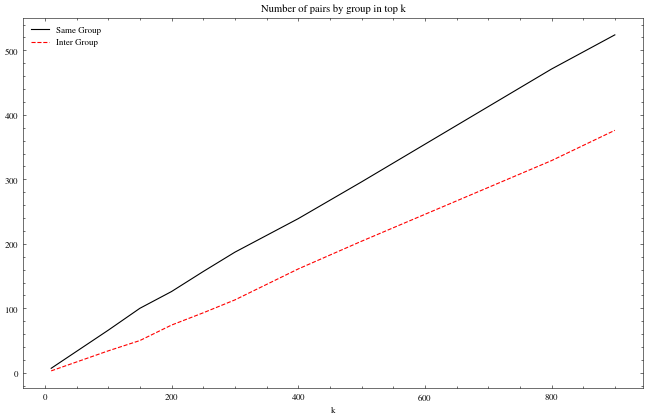

In [6]:
sorted_preds_idx = preds['test_pred'].sort().indices.flip(0)


same_group_results = []
inter_group_results = []
for k in ks:
    top_k_preds = adv_preds['test_true_adv'][sorted_preds_idx, :].argmax(1)[:k]
    same_group_results.append(((top_k_preds == 2) | (top_k_preds == 0)).sum())
    inter_group_results.append((top_k_preds == 1).sum()) 


plt.figure(figsize=(10, 6), dpi=80)
plt.rcdefaults()
plt.style.use(['science','ieee', 'no-latex'])
plt.plot(ks, same_group_results, label='Same Group')
plt.plot(ks, inter_group_results, label='Inter Group')
plt.legend()
plt.title('Number of pairs by group in top k')
plt.xlabel('k')
plt.show();

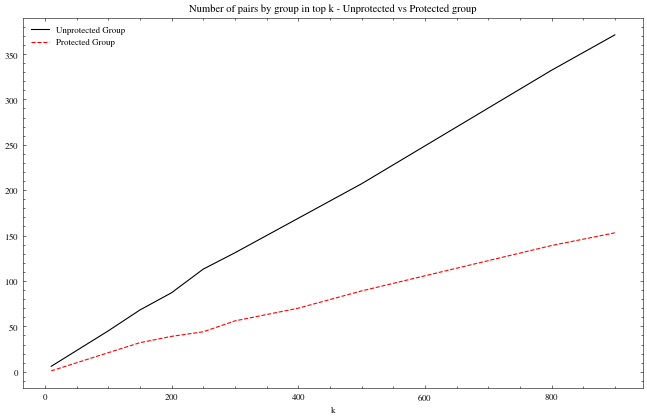

In [7]:
sorted_preds_idx = preds['test_pred'].sort().indices.flip(0)


protected_group_results = []
unprotected_group_results = []
for k in ks:
    top_k_preds = adv_preds['test_true_adv'][sorted_preds_idx, :].argmax(1)[:k]
    protected_group_results.append(((top_k_preds == 2)).sum())
    unprotected_group_results.append((top_k_preds == 0).sum()) 

plt.figure(figsize=(10, 6), dpi=80)
plt.rcdefaults()
plt.style.use(['science','ieee', 'no-latex'])
plt.plot(ks, unprotected_group_results, label='Unprotected Group')
plt.plot(ks, protected_group_results, label='Protected Group')
plt.legend()
plt.title('Number of pairs by group in top k - Unprotected vs Protected group')
plt.xlabel('k')
plt.show();

## Adversary model - Accuracy

In [8]:
adv_model_acc = (adv_preds['test_pred_adv'].argmax(1) == adv_preds['test_true_adv'].argmax(1)).sum() / len(adv_preds['test_pred_adv'])
adv_model_acc

tensor(0.6410)

In [9]:
adv_same_group_model_acc = (adv_preds['test_pred_adv'].argmax(1)[same_group_mask] == adv_preds['test_true_adv'].argmax(1)[same_group_mask]).sum() / len(adv_preds['test_true_adv'].argmax(1)[same_group_mask])
adv_same_group_model_acc

tensor(0.5207)

In [10]:
adv_inter_group_model_acc = (adv_preds['test_pred_adv'].argmax(1)[inter_group_mask] == adv_preds['test_true_adv'].argmax(1)[inter_group_mask]).sum() / len(adv_preds['test_true_adv'].argmax(1)[inter_group_mask])
adv_inter_group_model_acc

tensor(0.7935)

In [11]:
adv_protected_group_model_acc = (adv_preds['test_pred_adv'].argmax(1)[protected_group_mask] == adv_preds['test_true_adv'].argmax(1)[protected_group_mask]).sum() / len(adv_preds['test_true_adv'].argmax(1)[protected_group_mask])
adv_protected_group_model_acc

tensor(0.5421)

In [12]:
adv_unprotected_group_model_acc = (adv_preds['test_pred_adv'].argmax(1)[unprotected_group_mask] == adv_preds['test_true_adv'].argmax(1)[unprotected_group_mask]).sum() / len(adv_preds['test_true_adv'].argmax(1)[unprotected_group_mask])
adv_unprotected_group_model_acc

tensor(0.5136)